In [1]:
import sys
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

sys.path.append("..")
from geoobb.obb import geom_to_array, oriented_bounding_box

## Load Data


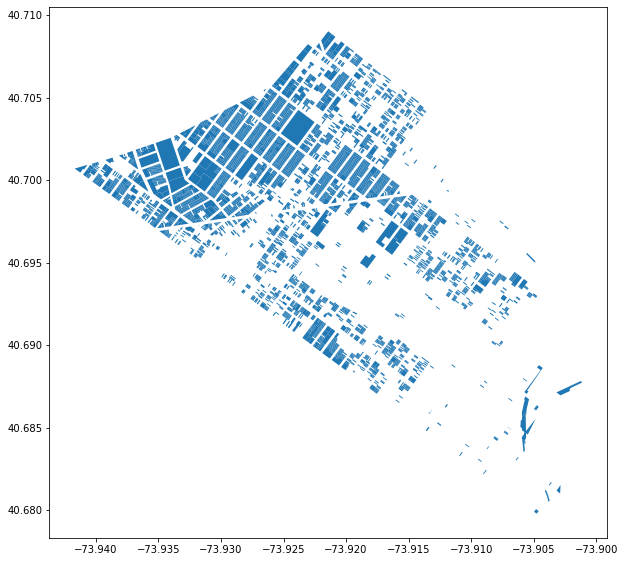

In [13]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 304',
    'f': 'pgeojson'
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text)

gdf.plot(figsize=(10, 10));

In [14]:
# the api has a max record limit of 4000
len(gdf)

4000

## Generate OBBs


In [8]:
%timeit gdf.geometry.map(geom_to_array)

1 loop, best of 3: 538 ms per loop


In [9]:
geo_arrs = gdf.geometry.map(geom_to_array)
%timeit geo_arrs.map(oriented_bounding_box)

1 loop, best of 3: 1.06 s per loop


Performance: pretty fast for 4,000 geometries!


## Determine Parcel Orientions


In [15]:
obbs = geo_arrs.map(oriented_bounding_box)